In [1]:
!pip install autogluon autogluon.tabular autogluon.common autogluon.core autogluon.features rapidfuzz unidecode sentence_transformers==3.0.1 scikit-learn==1.5.1 lightgbm==4.4.0 catboost==1.2.5 --no-deps --quiet

In [2]:
from sklearn.model_selection import GroupKFold, KFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import VotingRegressor

from autogluon.tabular import TabularDataset, TabularPredictor
from sentence_transformers import SentenceTransformer

import lightgbm as lgb
from lightgbm import LGBMRegressor, LGBMClassifier
from catboost import CatBoostRegressor, Pool, EShapCalcType, EFeaturesSelectionAlgorithm
from xgboost import XGBRegressor

from unidecode import unidecode
from rapidfuzz import process, fuzz
from dateutil.parser import parse

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import re
import shap
import pickle
import warnings

warnings.filterwarnings('ignore')

## 1. Verilerin Okunması

In [3]:
DATA_PATH = "/kaggle/input/datathon-2024"
MODEL_PATH = "/kaggle/input/btk-datathon-24-solution-files/models"
EXTRA_DATA_PATH = "/kaggle/input/btk-datathon-24-solution-files/extra_data"

FEATURE_SELECTION = False
TRAIN = False

In [4]:
train_df = pd.read_csv(f"{DATA_PATH}/train.csv").dropna(subset="Degerlendirme Puani")
test_df = pd.read_csv(f"{DATA_PATH}/test_x.csv")

## 2. Deney Şemasının Ayarlanması

Verinin içerisinde 9 yıla ait veriler bulunuyor. Kaggle senaryosunun taklit edilmesi adına her yılın ayrı ayrı test verisi seçilmesi ile yıl numarası grup kimliği olarak verilip **GroupKFold** veya tamamen **rastgele KFold** şeması kullanılabilir.

In [5]:
gkf = GroupKFold(n_splits=9)
splits = list(gkf.split(train_df, train_df, train_df["Basvuru Yili"]))

for fold_id, (tr_idx, val_idx) in enumerate(splits):
    train_df.loc[val_idx, "gkf_fold_id"] = int(fold_id)

train_df["gkf_fold_id"] = train_df["gkf_fold_id"].astype(int)

In [6]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)
splits = list(kf.split(train_df,train_df))

for fold_id, (tr_idx, val_idx) in enumerate(splits):
    train_df.loc[val_idx, "kf_fold_id"] = int(fold_id)

train_df["kf_fold_id"] = train_df["kf_fold_id"].astype(int)

## 3. Veri Analizi

### 3.1. Temel Dağılım İstatistikleri
Sadece yıl, etiket değeri ve burs yüzdelerinin sayı cinsinden ifade edildiğini görüyoruz.

In [7]:
train_df.describe(include = ['int', 'float'])

,Basvuru Yili,Degerlendirme Puani,Burslu ise Burs Yuzdesi,id,gkf_fold_id,kf_fold_id
count,65124.00000,65124.000000,22440.000000,65124.000000,65124.000000,65124.000000
mean,2018.27724,32.086466,34.226181,32561.500000,3.070942,1.999969
std,2.66996,18.139239,41.632412,18799.823802,2.347426,1.414214
min,2014.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2016.00000,18.000000,0.000000,16280.750000,1.000000,1.000000
50%,2019.00000,29.000000,0.000000,32561.500000,3.000000,2.000000
75%,2021.00000,44.000000,75.000000,48842.250000,5.000000,3.000000
max,2022.00000,102.000000,100.000000,65123.000000,8.000000,4.000000


Geri kalan bütün sütünların ise obje tipinde (yazı - NaN karışık) ifade edildiğini görüyoruz. Bunları model için fazla sparsity yaratıp öğrenmeyi zorlaştırmamaları adına işlememiz gerekecek.

In [8]:
for i in range(0,60,20):
    display(train_df[train_df.columns[i:i+20]].describe(include = ['object']))

,Cinsiyet,Dogum Tarihi,Dogum Yeri,Ikametgah Sehri,Universite Adi,Universite Turu,Burs Aliyor mu?,Bölüm,Universite Kacinci Sinif,Universite Not Ortalamasi,Daha Once Baska Bir Universiteden Mezun Olmus,Lise Adi,Lise Adi Diger,Lise Sehir,Lise Turu,Lise Bolumu,Lise Bolum Diger
count,64955,64947,64333,63087,64992,64869,65124,64893,64750,62371,27780,64740,4733,64070,64277,64115,1526
unique,4,13498,2230,319,527,4,5,7748,12,20,2,31950,4010,888,16,887,862
top,Kadın,1/1/70 2:00,İstanbul,İstanbul,İSTANBUL ÜNİVERSİTESİ,Devlet,Hayır,Endüstri Mühendisliği,2,3.00-2.50,Hayır,------,Atatürk Anadolu Lisesi,İstanbul,Anadolu Lisesi,Sayısal,Bilişim Teknolojileri
freq,32076,1655,8682,16625,2083,37884,51977,2434,21773,10758,26624,4251,8,8868,13367,28980,84


,Lise Mezuniyet Notu,Baska Bir Kurumdan Burs Aliyor mu?,Burs Aldigi Baska Kurum,Baska Kurumdan Aldigi Burs Miktari,Anne Egitim Durumu,Anne Calisma Durumu,Anne Sektor,Baba Egitim Durumu,Baba Calisma Durumu,Baba Sektor,Kardes Sayisi,Girisimcilik Kulupleri Tarzi Bir Kulube Uye misiniz?,Uye Oldugunuz Kulubun Ismi,Profesyonel Bir Spor Daliyla Mesgul musunuz?,Spor Dalindaki Rolunuz Nedir?,Aktif olarak bir STK üyesi misiniz?,Hangi STK'nin Uyesisiniz?,Stk Projesine Katildiniz Mi?,Girisimcilikle Ilgili Deneyiminiz Var Mi?,Girisimcilikle Ilgili Deneyiminizi Aciklayabilir misiniz?
count,59207,64893,21147,20962,64718,53228,30587,64117,52506,44746,63992.0,63295,16434,64009,32849,52282,15606,36817,52284,14598
unique,19,2,3959,587,21,3,8,22,3,8,28.0,2,13423,2,9,2,9489,2,2,9285
top,75 - 100,Hayır,-,-,İlkokul,Hayır,0,Lise,Evet,Özel Sektör,1.0,Hayır,IEEE,Hayır,0,Hayır,-,Hayır,Hayır,-
freq,22432,48513,4711,4724,10350,39370,11780,10008,28558,11293,16186.0,33709,203,42243,11315,37716,2956,19661,33919,5196


,Ingilizce Biliyor musunuz?,Ingilizce Seviyeniz?,"Daha Önceden Mezun Olunduysa, Mezun Olunan Üniversite"
count,58670,28592,419
unique,2,4,168
top,Evet,Orta,Anadolu Üniversitesi
freq,48871,13057,26


### 3.2. Özgün Değerler

En fazla özgün değeri ID ve doğum tarihi gibi kişiye özel değişen bilgilerde görmemiz normal. Fakat lise, kulüp ismi ve STK üyeliği gibi sütunların bu kadar özgün değere sahip olması garip bir durum. İlgili alanlar komple kullanıcıya manuel yazabilecekleri şekilde bırakılmış, sonuç olarak da yazım hataları yapılmış olabilir.

In [9]:
train_df.nunique().sort_values(ascending=False)[:10]

id                                                           65124
Lise Adi                                                     31950
Dogum Tarihi                                                 13498
Uye Oldugunuz Kulubun Ismi                                   13423
Hangi STK'nin Uyesisiniz?                                     9489
Girisimcilikle Ilgili Deneyiminizi Aciklayabilir misiniz?     9285
Bölüm                                                         7748
Lise Adi Diger                                                4010
Burs Aldigi Baska Kurum                                       3959
Dogum Yeri                                                    2230
dtype: int64

Lise isimlerini alfabetik sıralayıp baktığımızda bir çok yazım sorunuyla karşılaşıyoruz. İsimlerin başlarına boşluk koyma, komple büyük harfle yazım, parantez kullanımı, boş bırakmak yerine bir sembol yazmak gibi bir sürü uç senaryo mevcut.

In [10]:
sorted(list(train_df["Lise Adi"].unique().astype(str)))[:20]

[' Antalya Kepez Atatürk Anadolu Lisesi',
 ' BAHÇELIEVLER ŞEHIT OSMAN YILDIZ TICARET MESLEK ',
 ' Cumhuriyet Lisesi',
 ' Esenyurt lisesi',
 ' Çok programlı anadolu lisesi ',
 '(9-10-11)Yaşar Kımıl Fen Lisesi (12)Sınav Temel Lisesi',
 '(Söğütözü) Gazi Anadolu Lisesi',
 '-',
 '- FATİH KIZ ANADOLU İMAM HATİP LİSESİ (İSTANBUL - FATİH)',
 '------',
 '-Gaziantep Ömer Özmimar Anadolu İHL -Ankara Tevfik İleri Anadolu İHL. -İstanbul Tuzla Mahir İz Anadolu İHL(Açıköğretim Lisesi) (Son yazdığım okuldan mezun oldum, bunun sebebi son sınıfta İstanbul da bir kampa katılıp üniversiteye hazırlanmamdır)',
 '.',
 '.....',
 '0',
 '1.Murat Anadolu Lisesi',
 '10 Aralık Anadolu lisesi',
 '10 Aralık mesleki ve teknik Anadolu lisesi',
 '10 aralık mesleki ve teknik anadolu lisesi KASTAMONU',
 '10 numara',
 '10 saylı tam orta Mekteb']

Benzer bir durum STK üyeliği sütunu için de geçerli. Çoğu kullanıcı üyeliklerinin olduğu topluluğun ismini yazmak yerine deneyimlerini de açıklamış. Bu durum sütunun bize eksik aktarılması kaynaklı da olabilir. Bazı senelerde ilgili sütun sadece üyelik ismi için değil, deneyim için de kullanılabilecek şekilde değişik bir soruyla kullanıcıya gösterilmiş olabilir.

In [11]:
sorted(list(train_df["Hangi STK'nin Uyesisiniz?"].unique().astype(str)))[:5]

[' Aiesec',
 ' Genç engelliler Gençlik ve Spor Kulubü',
 '!Kızılay Gönüllüsü !Türkiye Eğitim Gönüllüleri Vakfı Gönüllsü (TEGV)',
 '"Aynı Dili Konuşalım" adında maddi durumu yetersiz ve dil öğrenme konusunda motivasyonu yüksek öğrencilere birçok farklı yabancı dili interaktif, canlı ve ücretsiz olarak öğretmeyi amaçladığımız gönüllülük projesinin iki kurucu ortağından biriyim. Son 1-1,5 yıldır çok yoğun bir şekilde projemizin fikirsel, teknik, iletişimsel, yönetimsel tüm süreçlerinde aktif olarak yer alıyorum. Bunun yanı sıra, "Düşlerim Gerçekleşiyor"da dezavantajlı çocukların gelişimi için gönüllü çalışmalarda bulunuyorum.',
 '"Spor İstanbul" aktif gönüllü üyesiyim.']

### 3.3. İkili Değerler İçin Ortalama Etiket Değerleri
Verideki evet-hayır sorularını hedef aldığımızda ise çoğu ek aktivite veya tecrübe ile ilgili soruların olumlu cevaplanması durumunda alınan puanın daha da yükseleceğini görebiliyoruz. Belirgin bir pozitif korelasyon mevcut.

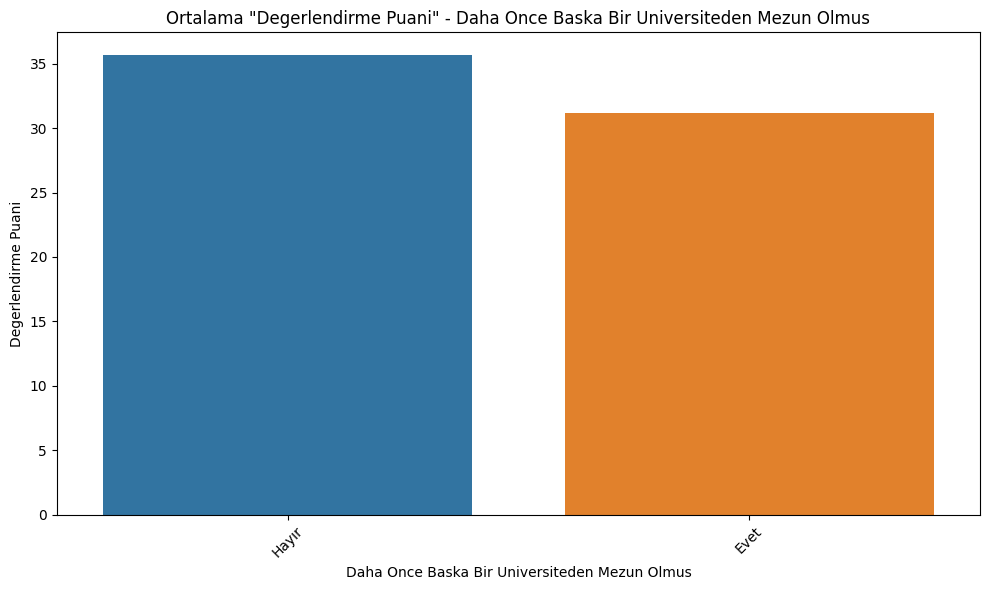

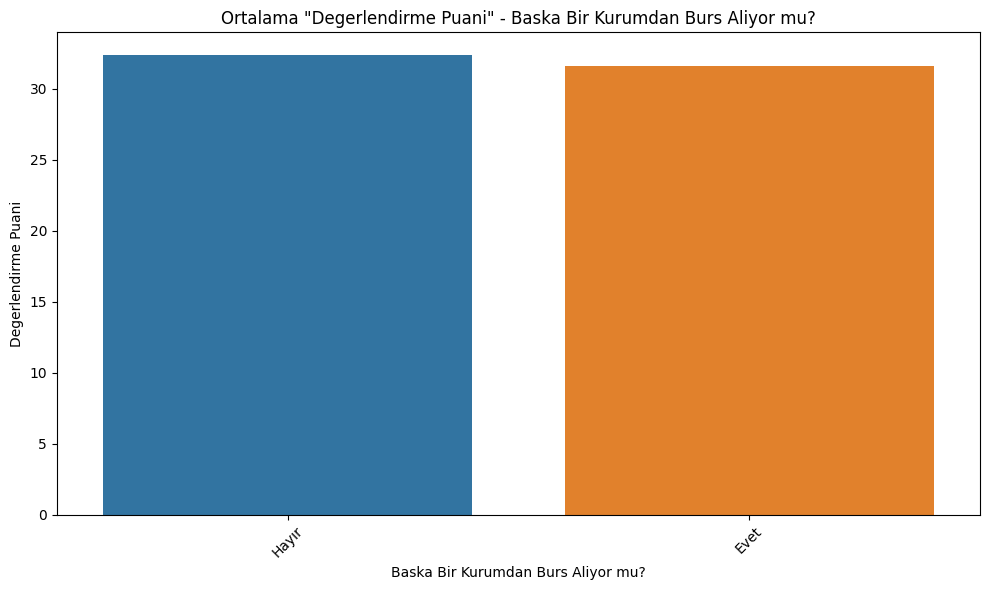

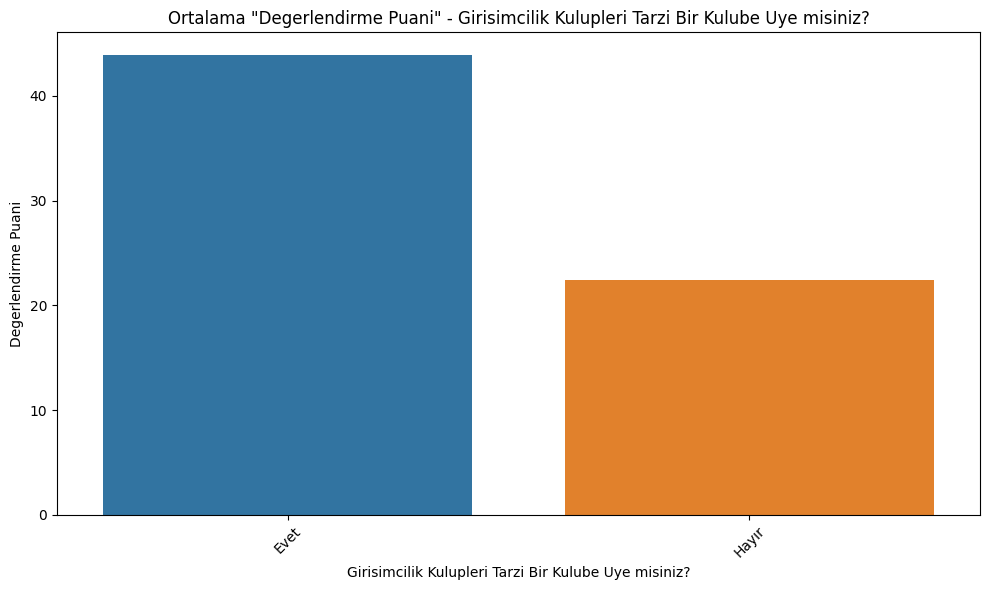

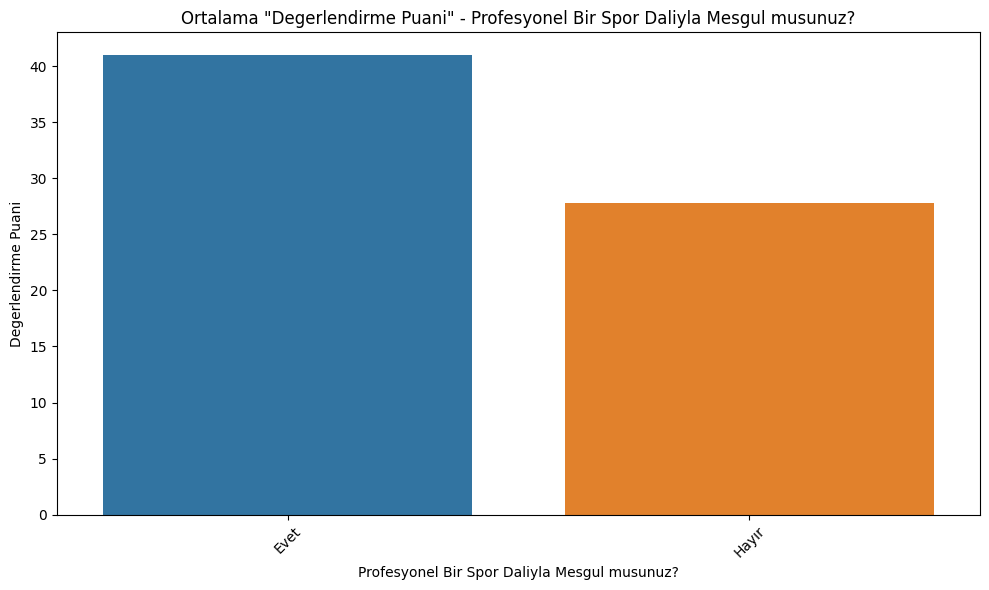

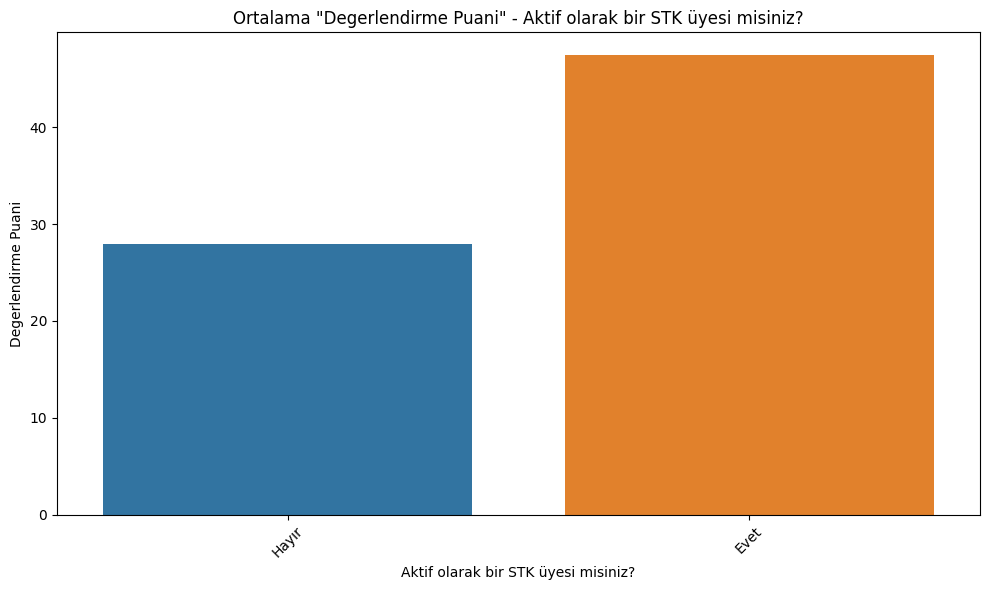

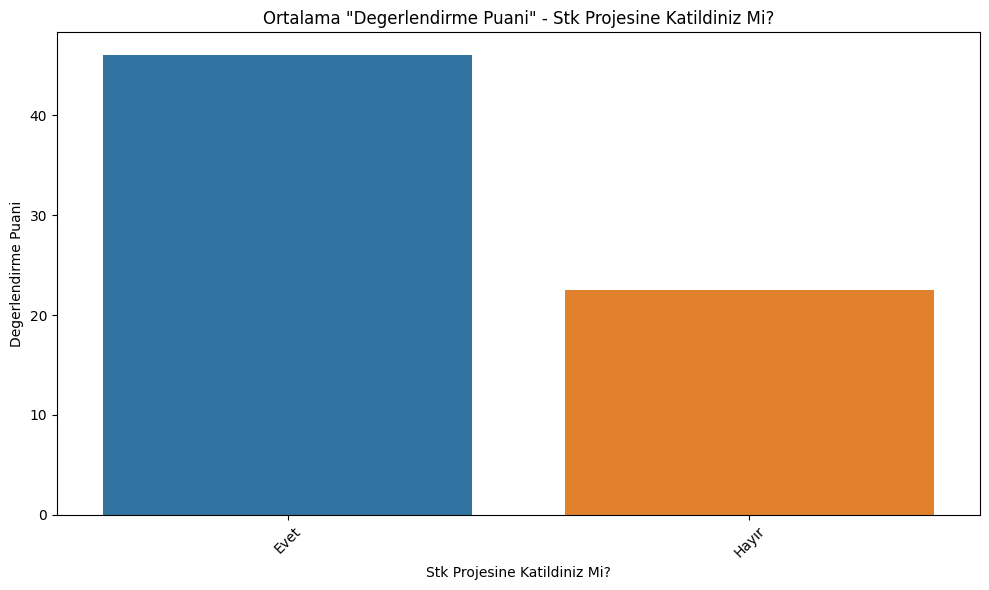

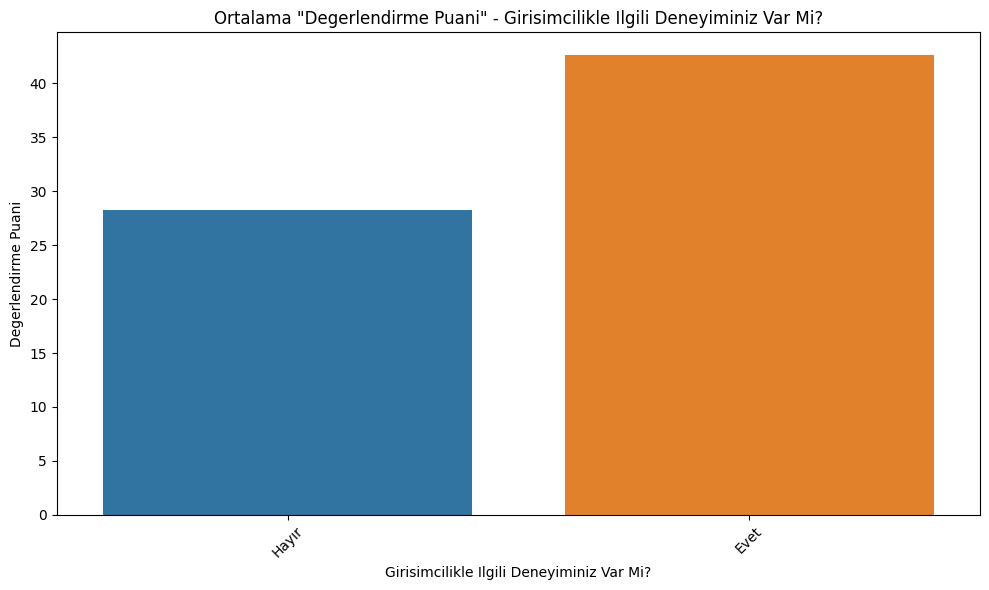

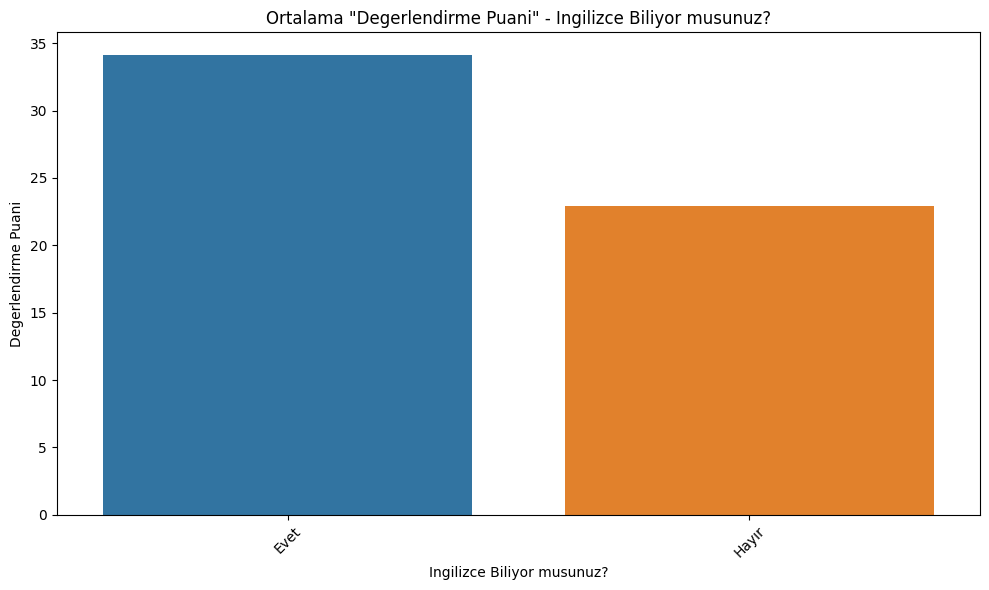

In [12]:
categorical_columns = [col for col in train_df.columns if train_df[col].nunique() == 2]

for col in categorical_columns:
    plt.figure(figsize=(10, 6))
    sns.barplot(x=train_df[col], y=train_df["Degerlendirme Puani"], estimator='mean', ci=None)
    plt.title(f'Ortalama "Degerlendirme Puani" - {col}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

### 3.4. Hedef Değerin Yıllara Göre Dağılımı
Hedef değerin çoğu yılda birbirine benzer ve right-skewed dağıldığını görebiliyoruz. Fakat 2016 yılı için aynı şeyi söylemek pek mümkün değil. Sanki sadece belirli notlardan aşağıda kalan notlar 2016 yılının verisetinden bilinçli şekilde düşürülmüş gibi duruyor.

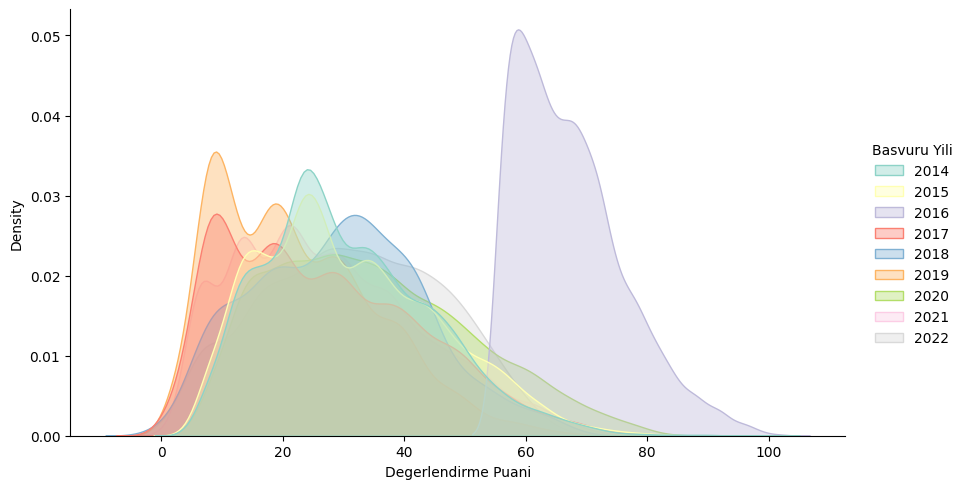

In [13]:
_ = sns.displot(kind='kde',
                data=train_df,
                x="Degerlendirme Puani",
                hue="Basvuru Yili",
                height=5,
                aspect=1.75,
                fill=True,
                common_norm=False,
                alpha=0.4,
                palette="Set3"
               )

### 3.5. Verideki Boş Sütunların Düzeni

Verideki sütunların boş değere sahip olma durumunu incelediğimizde bazı sütunların direk bloklar halinde bir süre boyunca dolu veya boş olduğunu görebiliyoruz. Veri kronolojik sıralı olduğundan bu bloklar yılları ifade ediyor olabilir.

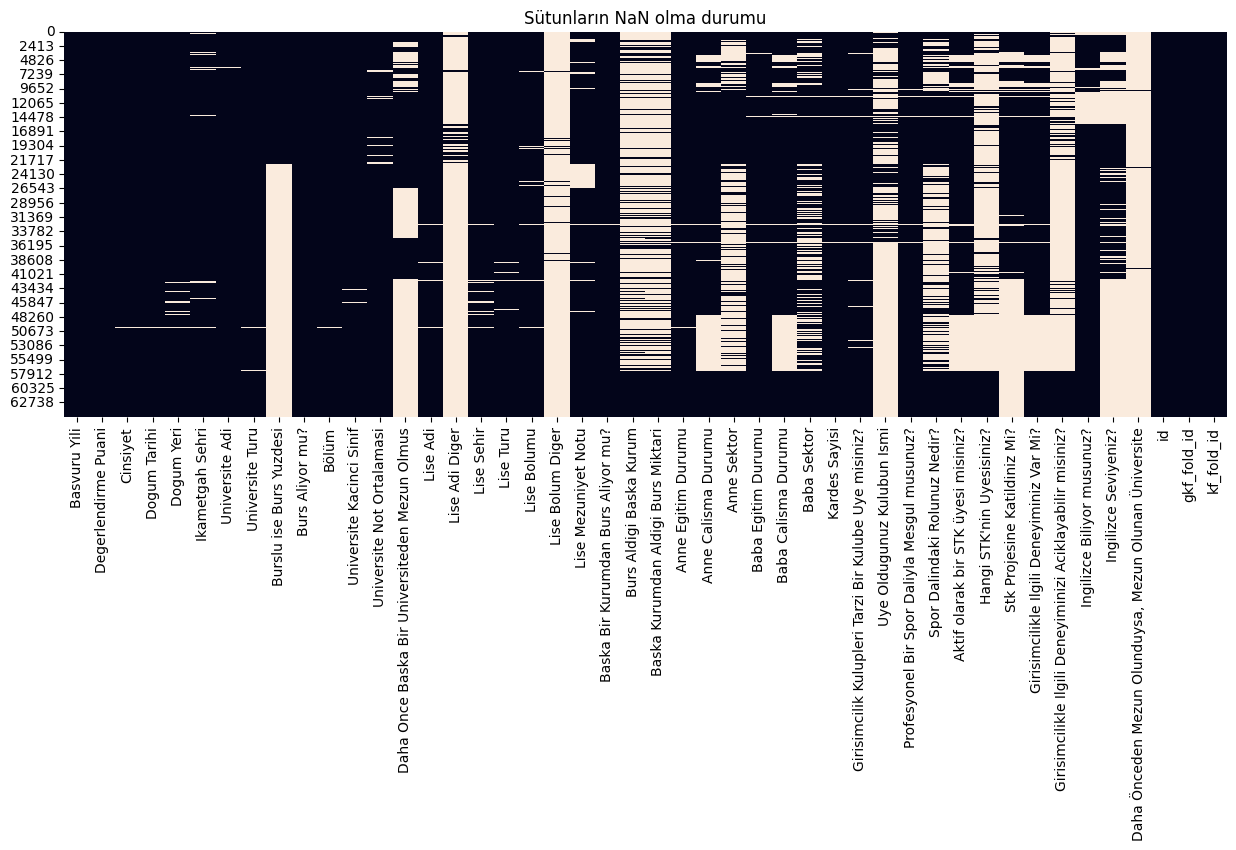

In [14]:
plt.figure(figsize=(15, 5))
sns.heatmap(train_df.isnull(), cbar=False)
plt.title('Sütunların NaN olma durumu')
plt.show()

#### 3.5.1. Yıla Özel Boş Olma Durumu
Veriyi incelediğimizde bazı sütunların bazı yıllarda komple boş olduğunu görebiliyoruz. Bu veriyi olduğu gibi kullanmak modelin her yıl için sütunların boş olma durumlarına overfit olarak etiket değerden ziyade herhangi bir yıla ait olma durumunu öğrenmesine yol açabilir.

In [15]:
print("Sütunlar vs Komple NaN oldukları yıllar")
print("-"*50)
print()

all_df = pd.concat([train_df, test_df], ignore_index=True)

colnan_dict = {col:[] for col in all_df.columns}

for year in all_df["Basvuru Yili"].unique():
    year_df = all_df[all_df["Basvuru Yili"] == year]
    year_df_na_counts = year_df.isna().sum()
    nan_cols = list(year_df_na_counts[year_df_na_counts==len(year_df)].index)

    for nan_col in nan_cols:
        colnan_dict[nan_col].append(year)

for col, years in colnan_dict.items():
    if len(years)>0:
        print(col, years)

Sütunlar vs Komple NaN oldukları yıllar
--------------------------------------------------

Degerlendirme Puani [2023]
Burslu ise Burs Yuzdesi [2022, 2023]
Daha Once Baska Bir Universiteden Mezun Olmus [2017, 2020, 2021, 2022, 2023]
Lise Adi Diger [2014, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
Lise Bolum Diger [2014, 2020, 2021, 2022, 2023]
Lise Mezuniyet Notu [2016]
Anne Calisma Durumu [2021]
Baba Calisma Durumu [2021]
Uye Oldugunuz Kulubun Ismi [2019, 2020, 2021, 2022, 2023]
Aktif olarak bir STK üyesi misiniz? [2021]
Hangi STK'nin Uyesisiniz? [2017, 2021]
Stk Projesine Katildiniz Mi? [2020, 2021, 2022, 2023]
Girisimcilikle Ilgili Deneyiminiz Var Mi? [2021]
Girisimcilikle Ilgili Deneyiminizi Aciklayabilir misiniz? [2016, 2017, 2018, 2019, 2021]
Ingilizce Biliyor musunuz? [2014]
Ingilizce Seviyeniz? [2014, 2020, 2021, 2022, 2023]
Daha Önceden Mezun Olunduysa, Mezun Olunan Üniversite [2014, 2015, 2017, 2020, 2021, 2022, 2023]
gkf_fold_id [2023]
kf_fold_id [2023]


#### 3.5.2. Yıl Sızıntısının Sağlaması

İlgili durumun yıl hakkında bir sızıntı yaratıp yaratmadığını **adversarial validation** ile test edebiliriz. Verimizi rastgele böldüğümüz ve modelden verinin hangi yıla ait olduğunu tahmin etmesini istediğimiz bir senaryoda eğer model rastgele bir tahminden daha başarılı bir sonuç üretebiliyorsa bu veride yıldan yıla değişen durumlar olduğunu, yani modelin sadece belli yıllar için geçerli olan genelleştirilemeyecek şeyler öğrenme ihtimali olduğunu gösterir. Bu, özellikle gelecek görülmemiş yılları tahmin edeceğimiz bir senaryoda istemeyeceğimiz bir eğitim tipidir.

In [16]:
advval_df = train_df.copy()
cat_cols = list(set([col for col in advval_df.columns if advval_df[col].dtype == object]))

for cat_col in cat_cols:
    advval_df[cat_col] = advval_df[cat_col].fillna("nan").astype(str).astype("category")
    
advval_df = advval_df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

cross_val_score(
    LGBMClassifier(n_estimators=1, verbosity=-1),
    advval_df.drop(columns=['BasvuruYili', 'DegerlendirmePuani', 'id', 'gkf_fold_id', 'kf_fold_id']),
    advval_df['BasvuruYili'],
    scoring="roc_auc_ovr",
    cv = 5)

array([0.99903629, 0.99801736, 0.99923996, 0.99745668, 0.93255323])

Sadece 1 iterasyon eğitilmiş LGBM modelinin bile rastgele tahminden öte neredeyse 100% başarı ile verinin hangi yıla ait olduğunu öğrenebiliyor olduğunu görüyoruz. Bu yüzden yıl bazında komple boş olan kategorik sütunları kullanmak maalesef performansı görülmemiş bir yıl için kötü etkileyecektir.

Test verimiz olan 2023 yılında boş olan sütunların bir tek **2022** yılı ile birebir aynı olduğunu farkettik. Burada dağılım tipini birebir temsil edebileceğini düşünerek sadece 2022 yılını da kullanmayı denedik. Sonuç olarak en yakın hata metriğini ve en düzgün korelasyonu sadece 2022 yılını eğitim verisi olarak kullandığımızda aldık.

## 4. Verinin Ayarlanması
Yukarıdaki analizlerimizdeki bulgularımızdan yola çıkarak sadece 2022 yılını seçiyoruz ve 2022-2023 yıllarında da komple boş olan sütunları veriden çıkarıyoruz.

In [17]:
train_df = train_df[train_df["Basvuru Yili"]==2022].reset_index(drop=True)

dropcols = [
    'Lise Bolum Diger',
    'Burslu ise Burs Yuzdesi',
    'Daha Once Baska Bir Universiteden Mezun Olmus',
    'Lise Adi Diger',
    'Stk Projesine Katildiniz Mi?',
    'Daha Önceden Mezun Olunduysa, Mezun Olunan Üniversite',
    'Ingilizce Seviyeniz?',
    'Uye Oldugunuz Kulubun Ismi'
]

train_df = train_df.drop(columns=dropcols)
test_df = test_df.drop(columns=dropcols)

KFold şemasını diğer yıllar da mevcutken oluşturmuş olmamıza rağmen 2022 yılı içerisinde foldların neredeyse eşit dağıldığını görebiliyoruz. Tekrardan bölmemize gerek yok.

In [18]:
train_df["kf_fold_id"].value_counts()

kf_fold_id
0    1553
1    1535
4    1527
3    1516
2    1490
Name: count, dtype: int64

## 5. Ek Veri Kullanımı

### 5.1. Üniversite Bölüm ve Fakülte Bilgileri
Üniversitelerin bölümlerini, puan türlerini ve ait oldukları fakülteleri barındıran YÖK Atlas çıktısını işledik. Parantez içerisinde belirtilen dil ve burs oranı bilgilerini kırparak bölüm başına genel bilgiyi elde ettik.

Kaynak: https://github.com/bersoy12/UniversityStudentAnalysis/

In [19]:
bolum_df = pd.read_csv(f"{EXTRA_DATA_PATH}/extra_uni_data/bolumler.csv", delimiter=";")
uni_bilgi_df = pd.read_csv(f"{EXTRA_DATA_PATH}/extra_uni_data/genel_bilgiler.csv", delimiter=";")

bolum_detay_df = uni_bilgi_df[["program_id", "fakulte_adi", "puan_turu"]].merge(bolum_df.drop(columns="uni_id"), how="left", on="program_id")
bolum_detay_df["program_adi"] = bolum_detay_df["program_adi"].str.replace(r"\(.*\)","", regex=True).str.strip()
bolum_detay_df = bolum_detay_df[["program_adi", "puan_turu", "fakulte_adi"]].drop_duplicates(subset="program_adi").reset_index(drop=True)

new_row = pd.DataFrame([{
    "fakulte_adi": "Diger",
    "puan_turu": "NULL",
    "program_adi": "Diger"
}])

bolum_detay_df = pd.concat([bolum_detay_df, new_row], ignore_index=True)
bolum_detay_df.head()

,program_adi,puan_turu,fakulte_adi
0,Psikoloji,EA,İnsan ve Toplum Bilimleri Fakültesi
1,Siyaset Bilimi ve Uluslararası İlişkiler,EA,İnsan ve Toplum Bilimleri Fakültesi
2,Mimarlık,SAY,Mimarlık Fakültesi
3,Bilgisayar Mühendisliği,SAY,Mühendislik Fakültesi
4,Elektrik-Elektronik Mühendisliği,SAY,Mühendislik Fakültesi


In [20]:
train_df["Bölüm"] = train_df["Bölüm"].apply(unidecode).str.lower()
test_df["Bölüm"] = test_df["Bölüm"].apply(unidecode).str.lower()
bolum_detay_df["program_adi"] = bolum_detay_df["program_adi"].apply(unidecode).str.lower()

reference_departments = list(bolum_detay_df["program_adi"].values)

# Eğitim verisinin işlenmesi
normalized_departments = [dep for dep in train_df["Bölüm"]]
mapped_departments = []
for dep in normalized_departments:
    match, score, _ = process.extractOne(dep, reference_departments, scorer=fuzz.token_sort_ratio)
    mapped_departments.append((dep, match, score))
map_df = pd.DataFrame(mapped_departments, columns=["Original", "Mapped", "Score"])
train_df["Bölüm_mapped"] = map_df["Mapped"]
train_df = train_df.merge(bolum_detay_df, how="left", left_on="Bölüm_mapped", right_on="program_adi")
train_df = train_df.drop(columns=["program_adi", "Bölüm_mapped"])
train_df["puan_turu"] = train_df["puan_turu"].fillna("NULL")
train_df = train_df.sort_values(by="id").reset_index(drop=True)

# Test verisinin işlenmesi
normalized_departments = [dep for dep in test_df["Bölüm"]]
mapped_departments = []
for dep in normalized_departments:
    match, score, _ = process.extractOne(dep, reference_departments, scorer=fuzz.token_sort_ratio)
    mapped_departments.append((dep, match, score))
map_df = pd.DataFrame(mapped_departments, columns=["Original", "Mapped", "Score"])
test_df["Bölüm_mapped"] = map_df["Mapped"]
test_df = test_df.merge(bolum_detay_df, how="left", left_on="Bölüm_mapped", right_on="program_adi")
test_df = test_df.drop(columns=["program_adi", "Bölüm_mapped"])
test_df["puan_turu"] = test_df["puan_turu"].fillna("NULL")
test_df = test_df.sort_values(by="id").reset_index(drop=True)

### 5.2. Üniversite - Şehir Bilgileri
Üniversiteleri ve bulundukları şehir bilgilerini barındıran YÖK Atlas çıktısını işledik.

Kaynak: https://github.com/bersoy12/UniversityStudentAnalysis/

In [21]:
uni_df = pd.read_csv(f"{EXTRA_DATA_PATH}/extra_uni_data/universiteler.csv", delimiter=";")
sehir_df = pd.read_csv(f"{EXTRA_DATA_PATH}/extra_uni_data/sehirler.csv", delimiter=";")

uni_sehir_df = uni_df.merge(sehir_df, how="left", on="sehir_id")
uni_sehir_df = uni_sehir_df.rename(columns={"sehir_adi": "sehir_uni"})[["uni_adi", "sehir_uni"]]
uni_sehir_df.to_csv("uni_sehir.csv", index=False)
uni_sehir_df.head()

,uni_adi,sehir_uni
0,Abdullah Gül Üniversitesi,Kayseri
1,Acıbadem Mehmet Ali Aydınlar Üniversitesi,İstanbul
2,Adana Alparslan Türkeş Bilim Ve Teknoloji Üniv...,Adana
3,Adıyaman Üniversitesi,Adıyaman
4,Afyon Kocatepe Üniversitesi,Afyonkarahisar


In [22]:
train_df["Universite Adi"] = train_df["Universite Adi"].apply(unidecode).str.lower()
test_df["Universite Adi"] = test_df["Universite Adi"].apply(unidecode).str.lower()
uni_sehir_df["uni_adi"] = uni_sehir_df["uni_adi"].apply(unidecode).str.lower()
uni_sehir_df["sehir_uni"] = uni_sehir_df["sehir_uni"].apply(unidecode).str.lower()

train_df = train_df.merge(uni_sehir_df, how="left", left_on="Universite Adi", right_on="uni_adi").sort_values(by="id").reset_index(drop=True)
test_df = test_df.merge(uni_sehir_df, how="left", left_on="Universite Adi", right_on="uni_adi").sort_values(by="id").reset_index(drop=True)

train_df["sehir_uni"] = train_df["sehir_uni"].fillna("UNKNOWN")
test_df["sehir_uni"] = test_df["sehir_uni"].fillna("UNKNOWN")

### 5.3. Şehir - Bölge Bilgileri
Türkiye'deki şehirleri ve ait oldukları bölgeleri içeren çıktıyı işledik.

Kaynak: https://github.com/yigith/TurkiyeSehirlerBolgeler/

In [23]:
sehirbolge_df = pd.read_excel(f"{EXTRA_DATA_PATH}/extra_sehirbolge_data/SehirlerBolgeler.xlsx")[["SehirAd", "Nufus", "BolgeAd"]]
sehirbolge_df.head()

,SehirAd,Nufus,BolgeAd
0,Adana,2201670,Akdeniz Bölgesi
1,Adıyaman,610484,Güneydoğu Anadolu Bölgesi
2,Afyonkarahisar,714523,Ege Bölgesi
3,Ağrı,542255,Doğu Anadolu Bölgesi
4,Amasya,326351,Karadeniz Bölgesi


In [24]:
sehirbolge_df["SehirAd"] = sehirbolge_df["SehirAd"].apply(unidecode).str.lower()
sehirbolge_df["BolgeAd"] = sehirbolge_df["BolgeAd"].apply(unidecode).str.lower()

train_df = train_df.merge(sehirbolge_df, how="left", left_on="sehir_uni", right_on="SehirAd").sort_values(by="id").reset_index(drop=True)
test_df = test_df.merge(sehirbolge_df, how="left", left_on="sehir_uni", right_on="SehirAd").sort_values(by="id").reset_index(drop=True)

train_df["BolgeAd"] = train_df["BolgeAd"].fillna("UNKNOWN")
test_df["BolgeAd"] = test_df["BolgeAd"].fillna("UNKNOWN")

## 6. Verinin Önişlenmesi

Verinin halihazırda bulunduğu hal doğrudan modele beslemek için uygun değil. Özellikle kategorik ve yazı sütunlarında düzensizlikler ve hatalar mevcut. Öncelikle bunların düzeltilmesi ve bir standarda sokulması gerekiyor.

### 6.1. Verinin Standart Hale Getirilmesi

Şehir sütunu için standardize edilmiş şehir isimlerinin oluşturulması ve eşleştirme fonksiyonu.

In [25]:
city_list = [
    'Adana', 'Adıyaman', 'Afyonkarahisar', 'Ağrı', 'Aksaray', 'Amasya', 'Ankara', 'Antalya', 
    'Ardahan', 'Artvin', 'Aydın', 'Balıkesir', 'Bartın', 'Batman', 'Bayburt', 'Bilecik', 
    'Bingöl', 'Bitlis', 'Bolu', 'Burdur', 'Bursa', 'Çanakkale', 'Çankırı', 'Çorum', 
    'Denizli', 'Diyarbakır', 'Düzce', 'Edirne', 'Elazığ', 'Erzincan', 'Erzurum', 'Eskişehir', 
    'Gaziantep', 'Giresun', 'Gümüşhane', 'Hakkari', 'Hatay', 'Iğdır', 'Isparta', 'İstanbul', 
    'İzmir', 'Kahramanmaraş', 'Karabük', 'Karaman', 'Kars', 'Kastamonu', 'Kayseri', 
    'Kilis', 'Kırıkkale', 'Kırklareli', 'Kırşehir', 'Kocaeli', 'Konya', 'Kütahya', 
    'Malatya', 'Manisa', 'Mardin', 'Mersin', 'Muğla', 'Muş', 'Nevşehir', 'Niğde', 'Ordu', 
    'Osmaniye', 'Rize', 'Sakarya', 'Samsun', 'Siirt', 'Sinop', 'Sivas', 'Şanlıurfa', 
    'Şırnak', 'Tekirdağ', 'Tokat', 'Trabzon', 'Tunceli', 'Uşak', 'Van', 'Yalova', 
    'Yozgat', 'Zonguldak'
]

city_list = [unidecode(city).lower() for city in city_list]

def find_city(ikametgah):
    for city in city_list:
        if city in unidecode(ikametgah).lower():
            return city
    return None

Farklı formatlarda yazılmış tarihlerden yıl bilgisini bulup çeken bulanık eşleştirme fonksiyonu.

In [26]:
def fuzzy_date_parse(dateval):
    try:
        return float(parse(dateval, fuzzy=True).year)
    except:
        return np.nan

Veriyi standardize eden bütün süreçleri barındıran ana fonksiyon. Ek açıklaması verilmemiş bütün satırlar yalnızca **unidecode** kütüphanesi kullanılarak yapılmış yazı normalizasyonunu içermektedir.

In [27]:
def standardize_data(inp_df, mode="train"):

    # Şehir bilgilerinin standardize edilmesi
    inp_df["Ikametgah Sehri"] = inp_df["Ikametgah Sehri"].fillna("").apply(find_city)
    inp_df["Dogum Yeri"] = inp_df["Dogum Yeri"].fillna("").apply(find_city)
    inp_df['Lise Sehir'] = inp_df['Lise Sehir'].fillna("").apply(find_city)

    inp_df["Cinsiyet"] = inp_df["Cinsiyet"].fillna("").str.lower()

    # Doğum tarihinden önce 4 haneli sayıların yıl olarak çekilmesi, kalan durumlar için bulanık eşleştirilmenin koşulması
    inp_df["Dogum Tarihi_org"] = inp_df["Dogum Tarihi"]
    inp_df['Dogum Tarihi'] = inp_df['Dogum Tarihi'].str.extract(r'(\d{4})')
    inp_df.loc[inp_df['Dogum Tarihi'].isna(), 'Dogum Tarihi'] = inp_df.loc[inp_df['Dogum Tarihi'].isna(), 'Dogum Tarihi_org']
    inp_df['Dogum Tarihi'] = inp_df['Dogum Tarihi'].apply(fuzzy_date_parse)
    inp_df = inp_df.drop(columns="Dogum Tarihi_org")

    
    inp_df["Universite Adi"] = inp_df["Universite Adi"].fillna("").apply(unidecode).str.lower()
    inp_df['Lise Adi'] = inp_df['Lise Adi'].fillna("").apply(unidecode).str.lower()

    # Üniversite türlerinin ordinal encode edilmesi
    inp_df["Universite Turu"] = inp_df["Universite Turu"].fillna("nan").apply(unidecode).str.lower().replace(
        {
            "ozel": 1.,
            "devlet": 0.,
            "nan": np.nan
        }
    )
    
    # Burs durumunun ordinal encode edilmesi    
    inp_df["Burs Aliyor mu?"] = inp_df["Burs Aliyor mu?"].fillna("nan").apply(unidecode).str.lower().replace(
        {
            "evet": 1,
            "hayir": 0,
            "nan": np.nan
        }
    )
    
    # Ek burs durumunun ordinal encode edilmesi
    inp_df['Baska Bir Kurumdan Burs Aliyor mu?'] = inp_df['Baska Bir Kurumdan Burs Aliyor mu?'].fillna("nan").apply(unidecode).str.lower().replace(
        {
            "evet": 1,
            "hayir": 0,
            "nan": np.nan
        }
    )    

    
    inp_df['Burs Aldigi Baska Kurum'] = inp_df['Burs Aldigi Baska Kurum'].fillna("").apply(unidecode).str.lower()    
    inp_df["Bölüm"] = inp_df["Bölüm"].fillna("").apply(unidecode).str.lower()
    inp_df["Lise Bolumu"] = inp_df["Lise Bolumu"].fillna("").apply(unidecode).str.lower()
    inp_df["Hangi STK'nin Uyesisiniz?"] = inp_df["Hangi STK'nin Uyesisiniz?"].fillna("").apply(unidecode).str.lower()


    # Üniversite sınıf ve seviyelerinin ordinal encode edilmesi (diğerleri halihazırda sayı olduğu için sadece yazı olanlar)
    inp_df['Universite Kacinci Sinif'] = inp_df["Universite Kacinci Sinif"].replace({
                                                                                        "Hazırlık": 0.,
                                                                                        "Mezun": 5.,
                                                                                        "hazırlık": 0.,
                                                                                        "Yüksek Lisans": 6.,
                                                                                        "Tez": 7.,        
                                                                                    }).astype(float)

    # Not ortalamalarının ordinal encode edilmesi
    if mode == "train":
        grade_avg_map = {
            '3.50-3': 3.,
            '3.00-2.50': 2.,
            '2.50 ve altı': 1,
            '3.00 - 4.00': 4,
            '3.50 - 4.00': 4.,
            '3.00 - 3.50': 3.,
            '2.50 -3.00': 2.,
            'Ortalama bulunmuyor': np.nan,
            'ORTALAMA BULUNMUYOR': np.nan,
            '4-3.5': 4.,
            '2.50 - 3.00': 2.,
            '2.00 - 2.50': 1.,
            '1.00 - 2.50': 1,
            'Not ortalaması yok': np.nan,
            '4.0-3.5': 4,
            '3.00 - 3.49': 3.,
            '2.50 - 2.99': 2.,
            '1.80 - 2.49': 1.,
            'Hazırlığım': np.nan,
            '0 - 1.79': 0.
        }
    elif mode == "test":
        grade_avg_map = {
            'Hazırlığım': np.nan,
            '0 - 1.79': 0.,
            '1.80 - 2.49': 1.,
            '2.50 - 2.99': 2.,
            '3.00 - 3.49': 3.,
            '3.50 - 4.00': 4.,
        }
        
    inp_df["Universite Not Ortalamasi"] = inp_df["Universite Not Ortalamasi"].replace(grade_avg_map).astype(float)

    # Lise türlerinin ordinal encode edilmesi
    lise_turu_map = {
        'Anadolu lisesi': 1.,
        'Meslek lisesi': 1.,
        'Fen lisesi': 1.,
        'Özel lisesi': 0.,
        'Düz lise': 1.,
        'İmam Hatip Lisesi': 1.,
        'Meslek Lisesi': 1.,
        'Fen Lisesi': 1.,
        'Düz Lise': 1.,
        'Anadolu Lisesi': 1.,
        'Özel Lise': 0.,
        'Özel Lisesi': 0.,
        'Diğer': np.nan,
        'Özel': 0.,
        'Meslek': 1.,
        'Devlet': 1.
    }
    
    inp_df['Lise Turu'] = inp_df['Lise Turu'].replace(lise_turu_map).astype(float)

    # Lise notlarının ordinal encode edilmesi
    if mode == "train":
        lise_not_map = {
            '3.50-3': 2.,
            '3.00 - 4.00': 2.,
            '3.00-2.50': 1.,
            '2.50 ve altı': 1.,
            '4.00-3.50': 2.,
            '3.50-3.00': 2.,
            '69-55': 1.,
            '100-85': 2.,
            '84-70': 2,
            '54-45': 0.,
            '44-0': 0.,
            '75 - 100': 2.,
            '50 - 75': 1.,
            'Not ortalaması yok': np.nan,
            '25 - 50': 0.,
            '0 - 25': 0.,
            '50 - 74': 1.,
            '25 - 49': 0.,
            '0 - 24': 0.
        }
        
    elif mode == "test":   
        lise_not_map = {
            '25 - 49': 0.,
            '50 - 74': 1.,
            '75 - 100': 2.
        }
    inp_df['Lise Mezuniyet Notu'] = inp_df['Lise Mezuniyet Notu'].replace(lise_not_map).astype(float)

    # Eğitim durumunun ordinal encode edilmesi
    education_map = {
        '0': 0.0,
        'doktora': 6.0,
        'egitim yok': 0.0,
        'egitimi yok': 0.0,
        'ilkokul': 1.0,
        'ilkokul mezunu': 1.0,
        'lise': 3.0,
        'lise mezunu': 3.0,
        'nan': np.nan,
        'ortaokul': 2.0,
        'ortaokul mezunu': 2.0,
        'universite': 4.0,
        'universite mezunu': 4.0,
        'yuksek lisans': 5.0,
        'yuksek lisans / doktara': 5.0,
        'yuksek lisans / doktora': 5.0
    }
    inp_df['Baba Egitim Durumu'] = inp_df['Baba Egitim Durumu'].fillna("nan").apply(unidecode).str.lower().replace(education_map).astype(float)
    inp_df['Anne Egitim Durumu'] = inp_df['Anne Egitim Durumu'].fillna("nan").apply(unidecode).str.lower().replace(education_map).astype(float)
    
    ####

    inp_df['Anne Calisma Durumu'] = inp_df['Anne Calisma Durumu'].fillna("nan").apply(unidecode).str.lower()
    inp_df['Baba Calisma Durumu'] = inp_df['Baba Calisma Durumu'].fillna("nan").apply(unidecode).str.lower()

    ####
    
    parent_sector_map = {
        '-': "nan",
        '0': "nan",
    }
    inp_df['Baba Sektor'] = inp_df['Baba Sektor'].fillna("nan").apply(unidecode).str.lower().replace(parent_sector_map)
    inp_df['Anne Sektor'] = inp_df['Anne Sektor'].fillna("nan").apply(unidecode).str.lower().replace(parent_sector_map)

    ####

    inp_df['Kardes Sayisi'] = inp_df['Kardes Sayisi'].replace({'Kardeş Sayısı 1 Ek Bilgi Aile Hk. Anne Vefat': 1.}).astype(float)

    # Girişimcilik kulüp üyeliğinin ordinal encode edilmesi
    inp_df['Girisimcilik Kulupleri Tarzi Bir Kulube Uye misiniz?'] =\
        inp_df['Girisimcilik Kulupleri Tarzi Bir Kulube Uye misiniz?'].fillna("nan").apply(unidecode).str.lower().replace(
        {
            "evet": 1.,
            "hayir": 0.,
            "nan": np.nan
        }
    )

    # Spor uğraş durumunun ordinal encode edilmesi
    inp_df['Profesyonel Bir Spor Daliyla Mesgul musunuz?'] =\
        inp_df['Profesyonel Bir Spor Daliyla Mesgul musunuz?'].fillna("nan").apply(unidecode).str.lower().replace(
        {
            "evet": 1.,
            "hayir": 0.,
            "nan": np.nan
        }
    )

    # Spor rol durumunun seviyeye göre ordinal encode edilmesi
    sport_role_map = {
        '-': 0.0,
        '0': 0.0,
        'bireysel': 1.0,
        'bireysel spor': 1.1,  # Aynı kategoriye yakın değerler atanabilir
        'diger': 2.0,  # Diğer genel bir kategori olarak ortalama bir değer alabilir
        'kaptan': 3.0,
        'kaptan / lider': 3.1,
        'lider/kaptan': 3.1,  # Benzer ifadeler aynı değeri alabilir
        'takim oyuncusu': 2.5  # Takım oyuncusu orta bir değer alabilir
    }
    inp_df['Spor Dalindaki Rolunuz Nedir?'] =\
        inp_df['Spor Dalindaki Rolunuz Nedir?'].fillna("nan").apply(unidecode).str.lower().replace(sport_role_map).astype(float)

    # Burs miktarının ordinal encode edilmesi
    baska_burs_map = {
        '-': 0.0, 
        '0-499₺': 1.0,
        '500₺-999₺': 2.0,
        '1000₺veüstü': 3.0
    }
    inp_df['Baska Kurumdan Aldigi Burs Miktari'] =\
        inp_df['Baska Kurumdan Aldigi Burs Miktari'].str.replace(" ", "").replace(baska_burs_map).astype(float)
    
    # STK üyeliğinin ordinal encode edilmesi
    inp_df['Aktif olarak bir STK üyesi misiniz?'] =\
        inp_df['Aktif olarak bir STK üyesi misiniz?'].fillna("nan").apply(unidecode).str.lower().replace(
        {
            "evet": 1.,
            "hayir": 0.,
            "nan": np.nan
        }
    )
    
    # Girişimcilik deneyiminin ordinal encode edilmesi
    inp_df['Girisimcilikle Ilgili Deneyiminiz Var Mi?'] =\
        inp_df['Girisimcilikle Ilgili Deneyiminiz Var Mi?'].fillna("nan").apply(unidecode).str.lower().replace(
        {
            "evet": 1.,
            "hayir": 0.,
            "nan": np.nan
        }
    )

    # İngilizce bilgisinin ordinal encode edilmesi
    inp_df['Ingilizce Biliyor musunuz?'] =\
        inp_df['Ingilizce Biliyor musunuz?'].fillna("nan").apply(unidecode).str.lower().replace(
        {
            "evet": 1.,
            "hayir": 0.,
            "nan": np.nan
        }
    )
    
    return inp_df

In [28]:
train_df = standardize_data(train_df, mode="train")
test_df = standardize_data(test_df, mode="train")

## 7. Feature Engineering
Verinin önişleme aşamasından sonra problem adına faydalı olabilecek ek değişkenleri türettik.

### 7.1. TF-IDF
- Üniversite adı
- Girişimcilik deneyimi
- Burs aldığı kurum
- Üniversite bölümü
 
sütunlarını kullanarak TFIDF matrixlerinin çıkarılması. Bu değerler bizlere döküman içerisinde belli bir orandan daha sık görünen ama yazı içerisinde ayrışan kelime ve kelime öbeklerini tespit edip kullanmamızı sağlayacak.

In [29]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3),
                             min_df=0.05)
train_embeddings = vectorizer.fit_transform(train_df["Universite Adi"].fillna(""))
test_embeddings = vectorizer.transform(test_df["Universite Adi"].fillna(""))

tfidf_df = pd.DataFrame(train_embeddings.toarray(), columns=[f"uniname_tfidf_{name}" for name in vectorizer.get_feature_names_out()])
train_df = pd.concat([train_df, tfidf_df], axis=1)

tfidf_df = pd.DataFrame(test_embeddings.toarray(), columns=[f"uniname_tfidf_{name}" for name in vectorizer.get_feature_names_out()])
test_df = pd.concat([test_df, tfidf_df], axis=1)

In [30]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3),
                             min_df=0.025)
train_embeddings = vectorizer.fit_transform(train_df['Girisimcilikle Ilgili Deneyiminizi Aciklayabilir misiniz?'].fillna(""))
test_embeddings = vectorizer.transform(test_df['Girisimcilikle Ilgili Deneyiminizi Aciklayabilir misiniz?'].fillna(""))

tfidf_df = pd.DataFrame(train_embeddings.toarray(), columns=[f"girisim_tfidf_{name}" for name in vectorizer.get_feature_names_out()])
train_df = pd.concat([train_df, tfidf_df], axis=1)

tfidf_df = pd.DataFrame(test_embeddings.toarray(), columns=[f"girisim_tfidf_{name}" for name in vectorizer.get_feature_names_out()])
test_df = pd.concat([test_df, tfidf_df], axis=1)

In [31]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2),
                             min_df=0.05)
train_embeddings = vectorizer.fit_transform(train_df['Burs Aldigi Baska Kurum'].fillna(""))
test_embeddings = vectorizer.transform(test_df['Burs Aldigi Baska Kurum'].fillna(""))

tfidf_df = pd.DataFrame(train_embeddings.toarray(), columns=[f"burs_kurum_tfidf_{name}" for name in vectorizer.get_feature_names_out()])
train_df = pd.concat([train_df, tfidf_df], axis=1)

tfidf_df = pd.DataFrame(test_embeddings.toarray(), columns=[f"burs_kurum_tfidf_{name}" for name in vectorizer.get_feature_names_out()])
test_df = pd.concat([test_df, tfidf_df], axis=1)

In [32]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2),
                             min_df=0.05)
train_embeddings = vectorizer.fit_transform(train_df['Bölüm'].fillna(""))
test_embeddings = vectorizer.transform(test_df['Bölüm'].fillna(""))

tfidf_df = pd.DataFrame(train_embeddings.toarray(), columns=[f"bolum_tfidf_{name}" for name in vectorizer.get_feature_names_out()])
train_df = pd.concat([train_df, tfidf_df], axis=1)

tfidf_df = pd.DataFrame(test_embeddings.toarray(), columns=[f"bolum_tfidf_{name}" for name in vectorizer.get_feature_names_out()])
test_df = pd.concat([test_df, tfidf_df], axis=1)

### 7.2. Turkish-BERT Embeddings
Türkçe bir BERT modeli kullanılarak girişimcilik deneyimi hakkında yazılmış yazıları semantik olarak temsil eden embedding vektörlerinin üretilmesi.

In [33]:
model = SentenceTransformer("dbmdz/bert-base-turkish-128k-uncased")
train_embeddings = model.encode(train_df['Girisimcilikle Ilgili Deneyiminizi Aciklayabilir misiniz?'].fillna(""))
test_embeddings = model.encode(test_df['Girisimcilikle Ilgili Deneyiminizi Aciklayabilir misiniz?'].fillna(""))
train_df[[f"nn_emb_{i}" for i in range(train_embeddings.shape[1])]] = train_embeddings
test_df[[f"nn_emb_{i}" for i in range(test_embeddings.shape[1])]] = test_embeddings

config.json:   0%|          | 0.00/386 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/740M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Batches:   0%|          | 0/239 [00:00<?, ?it/s]

Batches:   0%|          | 0/346 [00:00<?, ?it/s]

### 7.3. Ana Feature Engineering Rutini

Verilen binary sütunların kesişim (x) durumlarını belirten yeni sütunlar oluşturan fonksiyon.

In [34]:
def create_interactions(df, columns):
    interactions = pd.DataFrame()
    
    for i in range(len(columns)):
        for j in range(i+1, len(columns)):
            col1, col2 = columns[i], columns[j]
            interaction_col_name = f'{col1}_X_{col2}'
            interactions[interaction_col_name] = df[col1] * df[col2]
    
    return interactions

Geri kalan featureları çıkaran ana fonksiyon.

In [35]:
def feature_extract(inp_df):
    # Yaş bilgisi
    inp_df["age"] = inp_df["Basvuru Yili"] - inp_df["Dogum Tarihi"]

    # Bölüm değerinin içerdiği kelimelere göre çeşitli bölüm karakteristik bilgileri
    inp_df["bolum_cap"] = inp_df["Bölüm"].str.contains("cap").astype(int)
    inp_df["bolum_burs"] = inp_df["Bölüm"].str.contains("burs").astype(int)
    inp_df["bolum_ingilizce"] = inp_df["Bölüm"].str.contains("ingilizce").astype(int)
    inp_df["bolum_muhendis"] = inp_df["Bölüm"].str.contains("muhendis").astype(int)

    # Lise isminin içerdiği kelimelere göre çeşitli lise karakteristik bilgileri
    inp_df["lise_anadolu"] = inp_df['Lise Adi'].str.contains("anadolu").astype(int)
    inp_df["lise_fen"] = inp_df['Lise Adi'].str.contains("fen").astype(int)
    inp_df["lise_meslek"] = inp_df['Lise Adi'].str.contains("meslek").astype(int)

    # Burs kurumunun KYK kelimesini içerme durumu
    inp_df["kyk_burs"] = inp_df['Burs Aldigi Baska Kurum'].str.contains("kyk").astype(int)

    # Doğum-ikamet ve üniversite-ikamet şehirlerinin aynı veya farklı olma durumu
    inp_df["dogum_eq_ikamet"] = (inp_df['Dogum Yeri'] == inp_df['Ikametgah Sehri']).astype(int)
    inp_df["unisehir_eq_ikamet"] = (inp_df['sehir_uni'] == inp_df['Ikametgah Sehri']).astype(int)
    
    # Girişimcilik deneyimi ve üye olunan STK isminin uzunluğu
    inp_df["len_entr_story"] = inp_df['Girisimcilikle Ilgili Deneyiminizi Aciklayabilir misiniz?'].fillna("").apply(len)
    inp_df["len_stk_membership"] = inp_df["Hangi STK'nin Uyesisiniz?"].fillna("").apply(len)

    # Temsilen üniversiteye başlama yaşı
    inp_df["age_sub_grade"] = inp_df["age"] - inp_df['Universite Kacinci Sinif']

    # Yazı kalitesini temsilen okunabilirlik endeksi hesabı (Kaynak: "http://okunabilirlikindeksi.com/")
    vowels = "aeiou"
    inp_df["meanlen_words_entr_story"] = inp_df["Girisimcilikle Ilgili Deneyiminizi Aciklayabilir misiniz?"].fillna("").str.split().apply(lambda x: np.mean([len(elm) for elm in x])).replace(0,1)
    inp_df["meanvowel_words_entr_story"] = inp_df["Girisimcilikle Ilgili Deneyiminizi Aciklayabilir misiniz?"].fillna("").str.split().apply(lambda x: np.mean([sum(elm.count(vowel) for vowel in vowels) for elm in x])).replace(0,1)
    inp_df["meanlen_sents_entr_story"] = inp_df["Girisimcilikle Ilgili Deneyiminizi Aciklayabilir misiniz?"].fillna("").str.split(".").apply(lambda x: np.mean([len(elm) for elm in x])).replace(0,1)
    inp_df["meanwords_sents_entr_story"] = inp_df["Girisimcilikle Ilgili Deneyiminizi Aciklayabilir misiniz?"].fillna("").str.split(".").apply(lambda x: np.mean([len(elm.split()) for elm in x])).replace(0,1)
    inp_df["tr_readability"] = 198.825 - (inp_df["meanvowel_words_entr_story"] * 40.175) - (2.61 * inp_df["meanwords_sents_entr_story"])

    # Verilen sütunların ikililerinin aynı anda pozitif olma durumları
    interaction_df = create_interactions(inp_df, [
        "Aktif olarak bir STK üyesi misiniz?",
        "Girisimcilik Kulupleri Tarzi Bir Kulube Uye misiniz?",
        "Girisimcilikle Ilgili Deneyiminiz Var Mi?",
        "Profesyonel Bir Spor Daliyla Mesgul musunuz?",
        "Ingilizce Biliyor musunuz?"]
                                        )
    inp_df = pd.concat([inp_df, interaction_df], axis=1)    

    return inp_df

In [36]:
train_df = feature_extract(train_df)
test_df = feature_extract(test_df)

## 8. Eğitim - Validasyon - Tahminleme

Yazı sütunlarının düşürülmesi gereken ham halleri.

In [37]:
drop_cols = [
             "Hangi.STK'nin.Uyesisiniz?",
             'Girisimcilikle.Ilgili.Deneyiminizi.Aciklayabilir.misiniz?',
            ]

Sütun isimlerindeki boşluk karakteriyle uyumsuzluk yaşayan modellerden ötürü isimlerin değiştirilmesi.

In [38]:
train_df = train_df.rename(columns = lambda x: x.replace(' ', '.'))
test_df = test_df.rename(columns = lambda x: x.replace(' ', '.'))
cat_cols = list(set([col for col in train_df.columns if train_df[col].dtype == object]).difference(drop_cols))

### 8.1. Feature Seçimi
Belirlenmiş her fold üzerinde CatBoost modellerinin SHAP değerlerinden faydalanarak 5er aşamalı feature selection koşulması. Her fold'un sonuçları set-union yöntemiyle birleştirilerek final feature set elde edildi.

In [39]:
if FEATURE_SELECTION:
    summaries = []
    
    for fold_id in range(5):
        
        cv_train_df = train_df[train_df["kf_fold_id"] != fold_id]
        cv_val_df = train_df[train_df["kf_fold_id"] == fold_id]
        
        X_train, y_train = cv_train_df.drop(columns=["Degerlendirme.Puani", "id",
                                                     "kf_fold_id", "gkf_fold_id",
                                                     "Basvuru.Yili"
                                                    ] + [col.replace(' ', '.') for col in drop_cols]), cv_train_df["Degerlendirme.Puani"]
        
        X_val, y_val = cv_val_df.drop(columns=["Degerlendirme.Puani", "id",
                                                     "kf_fold_id", "gkf_fold_id",
                                                     "Basvuru.Yili"
                                                    ] + [col.replace(' ', '.') for col in drop_cols]), cv_val_df["Degerlendirme.Puani"]
                
        for cat_col in cat_cols:
            X_val[cat_col] = X_val[cat_col].fillna("nan").astype(str).astype("category")
            X_train[cat_col] = X_train[cat_col].fillna("nan").astype(str).astype("category")
        
        params = {
            'iterations': 3500,
            'learning_rate': 0.05,
            'depth': 5,
            "objective":'RMSE',
            'eval_metric': 'RMSE',
            'verbose': 100,
            'border_count':254,
            'task_type':'GPU',
            'use_best_model':False,
            "cat_features":cat_cols,
        }
        
        model = CatBoostRegressor(
            **params)
        
        train_pool = Pool(X_train, y_train, cat_features=cat_cols)
        test_pool = Pool(X_val, y_val, cat_features=cat_cols)
        
        summary = model.select_features(
            train_pool,
            eval_set=test_pool,
            features_for_select='0-873',
            num_features_to_select=25,
            steps=5,
            algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
            shap_calc_type=EShapCalcType.Regular,
            train_final_model=False,
            logging_level='Silent',
            plot=True
        )
        summaries.append(summary)
    
    selfeats = list(set(np.concatenate([summary["selected_features_names"] for summary in summaries])))

else:
    
    selfeats = [
        'Girisimcilikle.Ilgili.Deneyiminiz.Var.Mi?',
         'Dogum.Yeri',
         'Baba.Egitim.Durumu',
         'girisim_tfidf_devam',
         'girisim_tfidf_ile',
         'kyk_burs',
         'lise_fen',
         'Universite.Not.Ortalamasi',
         'bolum_muhendis',
         'girisim_tfidf_bu',
         'len_stk_membership',
         'Burs.Aldigi.Baska.Kurum',
         'Burs.Aliyor.mu?',
         'bolum_tfidf_muhendisligi',
         'girisim_tfidf_ve',
         'sehir_uni',
         'age',
         'dogum_eq_ikamet',
         'Ikametgah.Sehri',
         'bolum_tfidf_ogretmenligi',
         'len_entr_story',
         'Kardes.Sayisi',
         'uni_adi',
         'Universite.Adi',
         'bolum_tfidf_isletme',
         'Spor.Dalindaki.Rolunuz.Nedir?',
         'Girisimcilik.Kulupleri.Tarzi.Bir.Kulube.Uye.misiniz?',
         'lise_meslek',
         'Lise.Bolumu',
         'unisehir_eq_ikamet',
         'girisim_tfidf_da',
         'Cinsiyet',
         'Profesyonel.Bir.Spor.Daliyla.Mesgul.musunuz?',
         'Bölüm',
         'bolum_tfidf_bilgisayar.muhendisligi',
         'lise_anadolu',
         'Dogum.Tarihi',
         'uniname_tfidf_istanbul',
         'Ingilizce.Biliyor.musunuz?',
         'uniname_tfidf_universitesi',
         'Anne.Egitim.Durumu',
         'Baska.Bir.Kurumdan.Burs.Aliyor.mu?',
         'puan_turu',
         'Lise.Mezuniyet.Notu',
         'girisim_tfidf_aldım',
         'girisim_tfidf_sosyal',
         'Baba.Sektor',
         'Lise.Adi',
         'Universite.Turu',
         'Lise.Sehir',
         'girisim_tfidf_bir',
         'Aktif.olarak.bir.STK.üyesi.misiniz?',
         'girisim_tfidf_için',
         'fakulte_adi'
    ]

---
### 8.2. AutoGluon Modelleri
AutoGluon isimli auto-ml kütüphanesi kullanılarak bir çok tabular ve neural modelin de içinde bulunduğu baseline bir ensemble model seti eğitildi.

#### 8.2.1. Eğitim

In [40]:
if TRAIN:
    predictor = TabularPredictor(label="Degerlendirme.Puani",
                                 problem_type="regression",
                                 eval_metric="root_mean_squared_error",
                                 groups="kf_fold_id"
                                ).fit(train_df[selfeats + ["Degerlendirme.Puani", "kf_fold_id"]])
else:
    predictor = TabularPredictor.load(f"{MODEL_PATH}/autogluon")    

#### 8.2.2. Başarı Metrikleri
En başarılı tekil modellerin CatBoost ve LGBM olduğu görülebiliyor. En başarılı model ise hepsinin ağırlıklandırılarak kullanıldığı ensemble hal.

In [41]:
predictor.leaderboard()

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,-5.572205,root_mean_squared_error,0.573295,136.706019,0.000392,0.020355,2,True,12
1,CatBoost_BAG_L1,-5.614376,root_mean_squared_error,0.123170,44.046443,0.123170,44.046443,1,True,6
2,LightGBMXT_BAG_L1,-5.658774,root_mean_squared_error,0.043883,3.407001,0.043883,3.407001,1,True,3
3,LightGBM_BAG_L1,-5.761150,root_mean_squared_error,0.057727,4.618429,0.057727,4.618429,1,True,4
4,XGBoost_BAG_L1,-5.809189,root_mean_squared_error,0.103624,20.051978,0.103624,20.051978,1,True,9
5,LightGBMLarge_BAG_L1,-5.834033,root_mean_squared_error,0.079899,13.109528,0.079899,13.109528,1,True,11
6,ExtraTreesMSE_BAG_L1,-6.170458,root_mean_squared_error,0.296592,21.117993,0.296592,21.117993,1,True,7
7,RandomForestMSE_BAG_L1,-6.228550,root_mean_squared_error,0.298745,30.099227,0.298745,30.099227,1,True,5
8,NeuralNetFastAI_BAG_L1,-6.299608,root_mean_squared_error,0.150089,33.296597,0.150089,33.296597,1,True,8
9,NeuralNetTorch_BAG_L1,-6.425660,root_mean_squared_error,0.198034,51.317194,0.198034,51.317194,1,True,10


#### 8.2.3. Tahminleme

In [42]:
final_pred = predictor.predict(test_df[selfeats])
test_df["Degerlendirme Puani"] = final_pred
test_df["id"] = np.arange(len(test_df))
test_df[["id", "Degerlendirme Puani"]].to_csv("sub_autogluon.csv", index=False)
test_df[["id", "Degerlendirme Puani"]].head()

,id,Degerlendirme Puani
0,0,32.330585
1,1,21.809740
2,2,7.474794
3,3,17.219770
4,4,42.783752


---
### 8.3. Custom Model Akışı

Kendi parametrelerimize sahip CatBoost ve LGBM modellerini bir VotingRegressor şeması kullanarak eğittik.

#### 8.3.1. Ana Fonksiyon
Cross-validation ve final eğitim için kullanılacak eğitim döngüsünü içeren ana eğitim-validasyon fonksiyonu.

In [43]:
def folded_training(inp_df=None, fold_column="kf_fold_id", final_training=False):

    in_errors = []
    in_models = []

    for fold_id in range(5):
        print("\nFold ID:", fold_id)

        # Final eğitim veya CV eğitimi olma durumuna göre eğitim seti seçimi
        if final_training:
            cv_train_df = inp_df.copy()
        else:
            cv_train_df = inp_df[inp_df["kf_fold_id"] != fold_id]
            
        X_train, y_train = cv_train_df.drop(columns=["Degerlendirme.Puani", "id",
                                                     "kf_fold_id", "gkf_fold_id",
                                                     "Basvuru.Yili"
                                                    ] + [col.replace(' ', '.') for col in drop_cols]), cv_train_df["Degerlendirme.Puani"]

        # CV eğitimi olma durumuna göre validasyon seti seçimi        
        if not final_training:
            cv_val_df = inp_df[inp_df["kf_fold_id"] == fold_id]
            X_val, y_val = cv_val_df.drop(columns=["Degerlendirme.Puani", "id",
                                                   "kf_fold_id", "gkf_fold_id",
                                                   "Basvuru.Yili"
                                                  ] + [col.replace(' ', '.') for col in drop_cols]), cv_val_df["Degerlendirme.Puani"]

        for cat_col in cat_cols:
            X_train[cat_col] = X_train[cat_col].fillna("nan").astype(str).astype("category")
            if not final_training:
                X_val[cat_col] = X_val[cat_col].fillna("nan").astype(str).astype("category")

        # Verinin sadece seçilmiş featurelar ile maskelenmesi
        X_train = X_train[selfeats]

        if not final_training:
            X_val = X_val[selfeats]

        # CatBoost modelinin oluşturulması
        cb_params = {
            'iterations': 3500,
            'learning_rate': 0.05,
            'depth': 5,
            "objective":'RMSE',
            'eval_metric': 'RMSE',
            'verbose': 500,
            'border_count':254,
            'task_type':'GPU',
            'use_best_model':False,
            "cat_features":list(set(cat_cols).intersection(X_train.columns)),
        }
        
        if final_training:
            cb_params["random_state"] = fold_id
            
        catboost = CatBoostRegressor(**cb_params)

        # LGBM modelinin oluşturulması
        lgb_params = {
            'verbosity': -1,
            'depth': 1,
            'num_leaves': 2,
            "num_iterations":800,
            'learning_rate': 0.05,
        }  
        
        if final_training:
            lgb_params["random_state"] = fold_id
            
        lgbm = LGBMRegressor(**lgb_params)
            
        # LGB ve CatBoost modellerinden oluşan ensemble model
        base_estimators = [
            ("lgbm", lgbm),
            ("cb", catboost),
        ]    
        
        model = VotingRegressor(base_estimators)

        model.fit(X_train, y_train)

        # CV eğitimi olma durumuna göre validasyon tahminlerinin üretilmesi ve hata hesabı             
        if not final_training:
            pred = model.predict(X_val)
            error = mean_squared_error(y_val, pred,squared=False)
            in_errors.append(error)
            
        in_models.append(model)

    # CV eğitimi olma durumuna göre validasyon metriklerinin raporlanması       
    if not final_training:
        print("\nRMSE:", in_errors)
        print("RMSE (Ortalama):", np.mean(in_errors))
        print("RMSE (Standart Sapma):", np.std(in_errors))

    return in_models

#### 8.3.2. Cross-Validation
Sadece eğitim verisi için tanımlanmış foldlar kullanılarak cross-validated bir eğitimin koşulması ve sonuçların raporlanması.

In [44]:
if TRAIN:
    models = folded_training(inp_df=train_df, fold_column="kf_fold_id", final_training=False)

#### 8.3.3. Final Eğitim
Bütün veri kullanılarak final modellerin eğitilmesi. Bu sefer içerideki döngüdeki fold numarası modeller için seed state olarak kullanılacak.

In [45]:
if TRAIN:
    models = folded_training(inp_df=train_df, fold_column="kf_fold_id", final_training=True)
else:
    models = []
    for i in range(5):
        file = open(f"{MODEL_PATH}/custom/model{i}.voter",'rb')
        model = pickle.load(file)
        models.append(model)

#### 8.3.4. Tahminleme

In [46]:
for cat_col in cat_cols:
    test_df[cat_col] = test_df[cat_col].fillna("nan").astype(str).astype("category")
        
final_pred = []

for model in models:
    pred = model.predict(test_df[selfeats])
    final_pred.append(pred)
    
final_pred = np.mean(final_pred, axis=0)
test_df["Degerlendirme Puani"] = final_pred
test_df["id"] = np.arange(len(test_df))
test_df[["id", "Degerlendirme Puani"]].to_csv("sub_custom.csv", index=False)
test_df[["id", "Degerlendirme Puani"]].head()

,id,Degerlendirme Puani
0,0,32.780276
1,1,22.142027
2,2,6.760019
3,3,16.724972
4,4,41.516842


---
### 8.4. Model Blending
AutoGluon ve Custom modellerin tahminlerinin eşit ağırlıklandırma ile birleştirilmesi.

In [47]:
submission_df = test_df[['id']].copy()

submission_df['Degerlendirme Puani'] = (
    pd.read_csv('sub_autogluon.csv')['Degerlendirme Puani']*0.5
    +
    pd.read_csv('sub_custom.csv')['Degerlendirme Puani']*0.5
)

submission_df.to_csv('submission.csv', index=False)

submission_df.head()

,id,Degerlendirme Puani
0,0,32.555430
1,1,21.975884
2,2,7.117406
3,3,16.972371
4,4,42.150297


## 9. Çözüm Analizi

### 9.1. Feature Importance

Modelin en çok ikili değerler alan üyelik ve aktivite sütunlarını, sonrasında da not ortalaması ve üniversite bilgilerini önemsediğini görüyoruz.

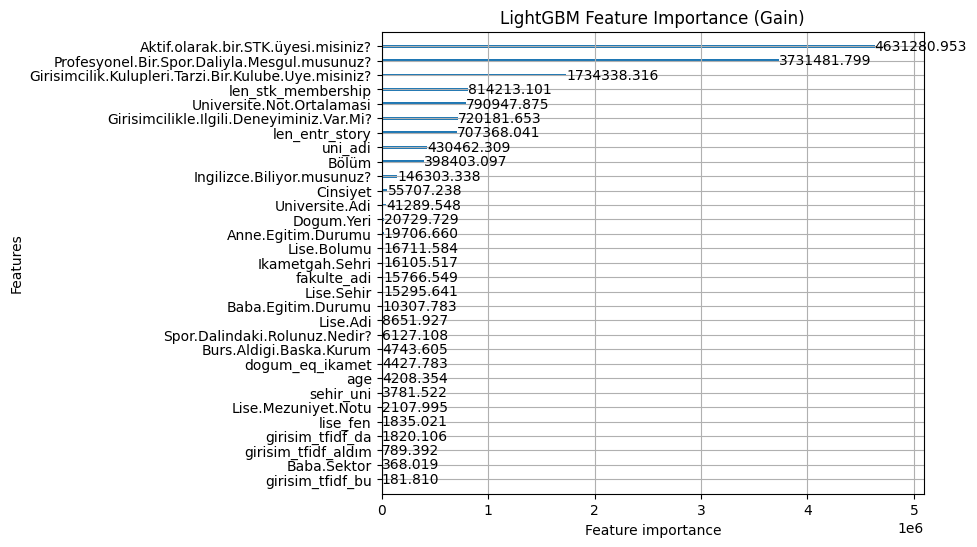

In [48]:
_ = lgb.plot_importance(model.estimators_[0], importance_type="gain", figsize=(7,6), title="LightGBM Feature Importance (Gain)")

### 9.2. SHAP Analizi
Modelin kararlarını vermesinde yine ikili değerler alan sütunlar oldukça önemli konumda. Ek bir aktivite ile uğraşıyor olmak veya bir topluluğa üye olmuş olmak modelin not yargısını belirgin bir şekilde yukarıya çekiyor. Geri kalan featurelarda daha dengeli bir tahmin dağılımı görmek mümkün.

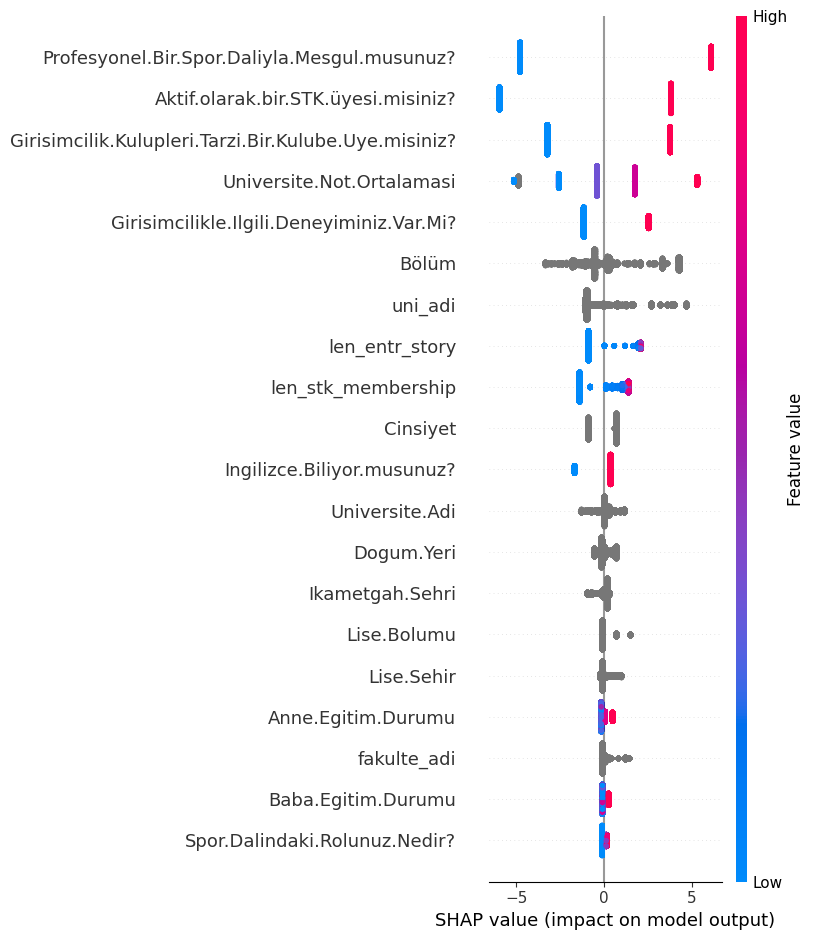

In [49]:
shap_values = shap.TreeExplainer(model.estimators_[0]).shap_values(test_df[selfeats])
shap.summary_plot(shap_values, test_df[selfeats])